In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import minimize
from scipy.signal import medfilt

In [2]:
data = np.load('final_set.npy', allow_pickle=True)
CATALOG = Table.read('/Users/arcticfox/Documents/youngStars/final_southern_catalog.txt',
                    format='ascii')

In [3]:
TICS = data[0]
TIME = data[1]
FLUX = data[2]
ERR = data[3]
PREDS = data[4]

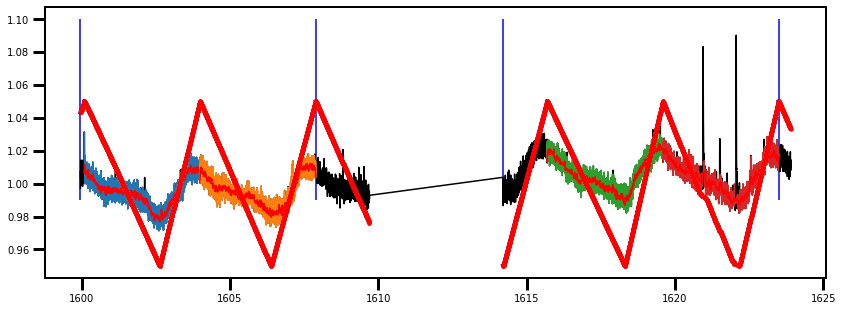

In [98]:
for i in [452]:
    plt.figure(figsize=(14,5))
    
    ## MASKS FLARES FOR FOLDING ON PERIOD
    noflare = ((PREDS[i] < 0.3) & (PREDS[i] > 0.0))
    
    plt.plot(TIME[i], FLUX[i], 'k')
    
    ## ASSIGNS MASKED LIGHT CURVE VARIABLES
    time, flux = TIME[i][noflare], FLUX[i][noflare]
    err = ERR[i][noflare]
    
    ## FINDS ORBITAL BREAK TO IGNORE
    diff = np.diff(time)
    orbit_break = np.where(diff > (np.nanmedian(diff) + 12*np.nanstd(diff)))[0]
    
    ## GETS MEASURED PERIOD
    params = CATALOG[CATALOG['TIC_ID']==float(TICS[i])]
    prot = np.nanmedian(params['period_days'].data)
    start = np.argmax(flux[np.where(time <= time[0]+prot)[0]])
    
    ## CREATES LIST OF ITERATIONS OF ROTATION PERIODS
    ## CUTS ON FULL ROTATION PERIODS ONLY (MIGHT CAUSE PROBLEM FOR LONGER BOIS L8R)
    rots = np.arange(0,200,1) * prot + time[start]
    
    rfull = ((rots < time[-1]-prot) &  (rots > time[0]) &
             ((rots <= time[orbit_break]-prot) | 
              (rots >= time[orbit_break+1])))
    rfull = rots[rfull]
    
    ## FINDS ROTATION PERIODS IN THE LIGHT CURVE
    rall = ((rots < time[-1]) & (rots > time[0]) & ((rots <= time[orbit_break]) | 
                                                    (rots >= time[orbit_break+1])))
    rall = np.sort(np.append(rots[rall], np.array([time[0], time[-2], 
                                                   time[orbit_break], 
                                                   time[orbit_break+1]])))

    ## FINDS PEAKS AND TROUGHS IN FULL ROTATION PERIODS ONLY
    phase_time, phase = [], []
    all_phases, all_phasetimes = np.array([]), np.array([])
    
    troughs, regions = np.array([], dtype=int), np.array([], dtype=int)
    for r in range(len(rfull)):
        region = np.where( (time >= rfull[r]) & (time < rfull[r]+prot) )[0]
        regions = np.append(regions, len(region))
        
        plt.plot(time[region], flux[region])
        mf = medfilt(flux[region], kernel_size=15)
        plt.plot(time[region], mf, 'r')
        minimum   = np.argmin(mf)
        troughs = np.append(troughs, minimum)
        
        phase_time.append(time[region])
        tp = np.append( np.linspace(0.5, -0.5, minimum),
                       np.linspace(-0.5, 0.5, len(region)-minimum) )
        phase.append(tp)
        plt.vlines(rfull[r], 0.99,1.1, 'w')

        if len(time[region]) != len(tp):
            print(len(time[region]), len(tp))
            
    for p in range(len(phase)):
        plt.plot(phase_time[p], phase[p]/10+1, 'w.', linewidth=3)
        
    interptime = np.arange(0,np.max(regions),1)
    interpphase = np.append(np.linspace(0.5,-0.5,int(np.nanmean(troughs))),
                  np.linspace(-0.5,0.5,len(interptime)-int(np.nanmean(troughs))))
        
    for r in range(len(rall)-1):
        if rall[r] not in rfull:
            region = np.where( (time >= rall[r]) & (time <= rall[r+1]))[0]
            if len(region) > 5:
                plt.vlines(rall[r], 0.99,1.1, 'b')

                if rall[r+1] in rfull:
                    phaseregion = [len(interpphase)-len(region), len(interpphase)]

                else:
                    phaseregion = [0, len(region)]

                plt.plot(time[region], interpphase[phaseregion[0]:phaseregion[1]]/10+1,
                        'b', linewidth=4)
                phase_time.append(time[region])
                phase.append(interpphase[phaseregion[0]:phaseregion[1]])

    for p in range(len(phase)):
        all_phases = np.append(all_phases, phase[p])
        all_phasetimes = np.append(all_phasetimes, phase_time[p])

    all_phasetimes, all_phases = zip(*sorted(zip(all_phasetimes, all_phases)))
    all_phasetimes, all_phases = np.array(all_phasetimes), np.array(all_phases)
    
    plt.plot(all_phasetimes, all_phases/10+1, 'r.')
    
    plt.show()
  

In [94]:
len(time), len(all_phasetimes)

(17611, 17611)

In [57]:
# running median
# extrapolate from not 1st and last rotation periods
# fold but dont fold on tooooo much data
